# Projet SY09 - Bigfoot

## Import des bibiliothèques

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

from datetime import datetime

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from utils import plot_clustering, add_decision_boundary

## Chargement du jeu de données

In [2]:
# importer données du fichier csv
bigfoot = pd.read_csv("../data/bigfoot.csv", sep = ",")

### Mise en forme du jeu de données
#### Ajout et suppression de colonnes

In [3]:
# ajoute des colonnes jour, mois, année=
year = bigfoot['date'].copy()
month = bigfoot['date'].copy()
day = bigfoot['date'].copy()

for i in range(bigfoot['date'].size):
    d = bigfoot['date'][i]
    if str(d) != "nan":
        d_datetime = datetime.strptime(str(d),'%Y-%m-%d')
        year[i] = d_datetime.year
        month[i] = d_datetime.month
        day[i] = d_datetime.day

bigfoot = bigfoot.assign(year = year)
bigfoot = bigfoot.assign(month = month)
bigfoot = bigfoot.assign(day = day)

bigfoot.drop(columns="geohash", inplace=True)
bigfoot.drop(columns="date", inplace=True)

#### Conversion d'unité et mise en forme des données

In [4]:
# temperature_high : fahrenheit en celsius
# temperature_mid : fahrenheit en celsius
# temperature_low : fahrenheit en celsius
# dew_point : fahrenheit en celsius
# wind_speed : miles par heure en kilomètre par heure
# precip_intensity : inch en cm
# visibility : miles en kilomètre
# latitude / longitude : coordonnées polaires

bigfoot = bigfoot.assign(
    temperature_high = (bigfoot.temperature_high - 32) * 5 / 9,
    temperature_mid = (bigfoot.temperature_mid - 32) * 5 / 9,
    temperature_low = (bigfoot.temperature_low - 32) * 5 / 9,
    dew_point = (bigfoot.dew_point - 32) * 5 / 9,
    wind_speed = bigfoot.wind_speed * 1.609344,
    precip_intensity = bigfoot.precip_intensity * 2.54,
    visibility = bigfoot.visibility * 1.609344,
    r = np.sqrt(bigfoot.longitude ** 2 + bigfoot.latitude ** 2 ),
    theta = 2 * np.arctan( bigfoot.latitude / ( bigfoot.longitude + np.sqrt(bigfoot.longitude ** 2 + bigfoot.latitude ** 2 )))
)

# pour le "titre" garde la partie [titre] du format inital “Report [numéro] : [titre]”

bigfoot = bigfoot.assign(
    title = bigfoot.title.str.replace(r'^Report \d*: ', '')
)

# transformation de precip_type en deux colonnes snow et rain
bigfoot["rain"] = 0.0
bigfoot.loc[bigfoot.precip_type == "rain", "rain"] = 1.0
bigfoot["snow"] = 0.0
bigfoot.loc[bigfoot.precip_type == "snow", "snow"] = 1.0
bigfoot["summer"] = 0.0
bigfoot.loc[bigfoot.season == "Summer", "summer"] = 1.0
bigfoot["spring"] = 0.0
bigfoot.loc[bigfoot.season == "Spring", "spring"] = 1.0
bigfoot["fall"] = 0.0
bigfoot.loc[bigfoot.season == "Fall", "fall"] = 1.0
bigfoot["winter"] = 0.0
bigfoot.loc[bigfoot.season == "Winter", "winter"] = 1.0

/tmp/ipykernel_31541/2260502135.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  title = bigfoot.title.str.replace(r'^Report \d*: ', '')


#### Conversion des types

In [5]:
# dictionnaire des états des Etats-Unis et leur abbrévation

us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
}

In [6]:
# variables catégorielles

bigfoot.county = pd.Categorical(bigfoot.county)
bigfoot.state = pd.Categorical(bigfoot.state, categories=us_state_to_abbrev.keys())

bigfoot.classification = bigfoot.classification.replace("Class A", "A")
bigfoot.classification = bigfoot.classification.replace("Class B", "B")
bigfoot.classification = bigfoot.classification.replace("Class C", "C")
bigfoot.classification = pd.Categorical(bigfoot.classification, categories=["A", "B", "C"], ordered=True)

bigfoot.drop(columns=["precip_type"], inplace=True)
bigfoot.drop(columns=["season"], inplace=True)

In [7]:
# types des variables

# Attention! Conséquence, variables catégorielles ont des valeurs <NA> à la place de NaN.

bigfoot.observed = bigfoot.observed.astype('string')
bigfoot.location_details = bigfoot.location_details.astype('string')
bigfoot.title = bigfoot.title.astype('string')
bigfoot.summary = bigfoot.summary.astype('string')

bigfoot.number = bigfoot.number.astype('Int64')

bigfoot.day = bigfoot.day.astype(float)
bigfoot.month = bigfoot.month.astype(float)
bigfoot.year = bigfoot.year.astype(float)

### Conversion des variables et corrélations

In [8]:
bigfoot.drop(columns=["temperature_high", "temperature_low", "dew_point"], inplace=True)

features = [
    'summer',
    'winter',
    'fall',
    'spring',
    'r',
    'theta',
    'temperature_mid',
    'humidity',
    'cloud_cover',
    'moon_phase',
    'precip_intensity',
    'precip_probability',
    'rain',
    'snow',
    'pressure',
    'uv_index',
    'visibility',
    'wind_bearing',
    'wind_speed',
    'year',
    'month',
    'day'
    ]

numeric_cols = [
    'r',
    'theta',
    'temperature_mid',
    'humidity',
    'cloud_cover',
    'moon_phase',
    'precip_intensity',
    'precip_probability',
    'pressure',
    'uv_index',
    'visibility',
    'wind_bearing',
    'wind_speed',
    'year',
    'month',
    'day'
]

cat_cols = [
    'summer',
    'winter',
    'fall',
    'spring',
    'rain',
    'snow'
]

## K plus proches voisins

In [9]:
def fill_missing(df):
    '''
    replace empty values by column's mean in dataframe
    '''
    return df.copy().fillna(df.mean())

In [10]:
def calculate_zscore(df):
    '''
    scales columns in dataframe using z-score
    '''
    df = df.copy()
    for col in df.columns:
        df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)

    return df

In [11]:
def normalize_column_modality(df):
    '''
    divides each column by the probability μₘ of the modality 
    (number of ones in the column divided by N) only for one hot columns
    '''
    df = df.copy()
    length = len(df)
    for col in df.columns:
        weight = math.sqrt(sum(df[col])/length)
        df[col] = df[col]/weight

    return df

In [12]:
def center_columns(df):
    '''
    center columns by subtracting the mean value
    '''
    df = df.copy()
    for col in df.columns:
        df[col] = (df[col] - df[col].mean())
    return df

In [13]:
bigfoot_famd_num = pd.DataFrame(calculate_zscore(fill_missing(bigfoot[numeric_cols])))
bigfoot_famd_cat = center_columns(normalize_column_modality(bigfoot[cat_cols]))
bigfoot_famd = pd.concat([bigfoot_famd_num, bigfoot_famd_cat], axis=1)

(<AxesSubplot: xlabel='PC1', ylabel='PC2'>, PCA(n_components=2))

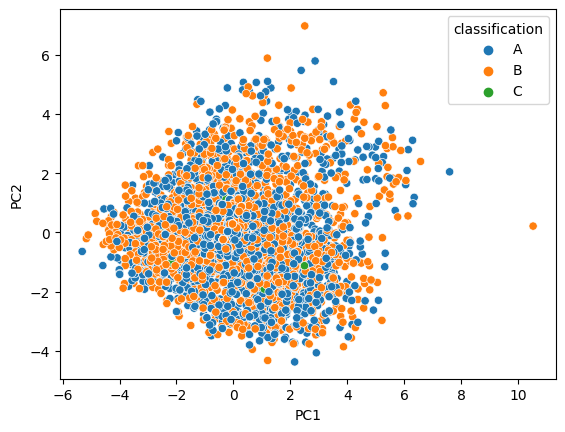

In [14]:
plot_clustering(bigfoot_famd, bigfoot.classification)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(bigfoot_famd, bigfoot.classification, train_size=0.66)

In [25]:
cls = KNeighborsClassifier(n_neighbors=5)
cls.fit(X_train, y_train)
labels = cls.predict(X_val)
accuracy_score(labels, y_val)

0.5345433255269321